In [33]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating project at `~/Documents/Robotics/CMU-Optimal-Control/HW1_S23`


# Q2 (20 pts): Augmented Lagrangian Quadratic Program Solver

## Part (A): QP Solver (10 pts)
Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
s.t. \quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.

The lagrangian and augmented lagrangian are
$$\begin{align}

L(x, \lambda, \mu) = \quad \frac{1}{2}x^TQx + q^Tx+\lambda^\intercal (Ax-B) + \mu^\intercal (Gx-h) \\
L~{\rho}~ (x,\lambda,\mu,\rho) = L(x, \lambda, \mu) + \frac{\rho}{2}* (Ax-B)^\intercal (Ax-B) +\frac{1}{2} (Gx-h)^\intercal I~\rho~ (Gx-h)


\end{align}$$

By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:


$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [34]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:

as long as solve_qp works. 
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    mat = zeros(length(μ), length(μ))
    for k = 1:length(μ)
        if h_ineq(qp,x)[k] <0 && μ[k]==0
            mat[k,k] = 0
        else
            mat[k,k] = ρ
        end
    end
    return mat
end

function lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector)::Real

    cost(qp,x)+λ'*c_eq(qp,x) + μ'h_ineq(qp,x)
    
end

function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real

    lagrangian(qp,x,λ,μ) + 0.5*ρ*c_eq(qp,x)'*c_eq(qp,x) +0.5*h_ineq(qp,x)'*mask_matrix(qp,x,μ,ρ)*h_ineq(qp,x)

end

function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm

    stationarity_norm = norm(AL_gradient)

    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end



logging (generic function with 1 method)

In [35]:
# function merit_function(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)
#     k = [
#         FD.gradient(_x -> augmented_lagrangian(qp,_x, λ, μ, ρ), x);
#         min.(0, c_eq(qp,x));
#         h_ineq(qp, x)
#     ]
#     return 0.5 * norm(k)^2
# end

function merit_function(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    return augmented_lagrangian(qp,x,λ,μ,ρ)
end


function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
    max_ls_iters=300)::Float64
    alpha = 1.0
    b = 1e-3
    grad_merit_fx(z) = FD.gradient(merit_fx, z)
    for i = 1:max_ls_iters
        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z) 
        if merit_fx(z + alpha * Δz) < merit_fx(z) + b * alpha * grad_merit_fx(z)' * Δz
            return alpha
        else
            alpha /= 2
        end
    end
    error("linesearch failed")
end


function newtons_method(z0::Vector, res_fx::Function, jac_res_fx::Function, merit_function::Function, iter_num::Integer;
    tol=1e-4, max_iters=300, verbose=true)
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 #initial values

    for i = 1:(max_iters-1)
        norm_r = norm(res_fx(Z[i]))
        if norm_r < tol
            print("iteration_number: $iter_num \n")
            return Z[i]
        end
        H = jac_res_fx(Z[i])
        J = res_fx(Z[i])
        #regularization
        β = 0.5
        while !isposdef(H)
            H = H + β * I
        end
        Δz = -H\J
        α = linesearch(Z[i], Δz, merit_function)
        Z[i+1] = Z[i] + α * Δz
    end
    error("Newton's method did not converge")
end

newtons_method (generic function with 1 method)

In [40]:

function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q)) # vector of length n
    λ = zeros(length(qp.b)) # vector of length m
    μ = zeros(length(qp.h)) # vector of length p
    ρ = 1.0
    ϕ = 10.0
    
    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    
    # TODO:


    for main_iter = 1:max_iters 

        if verbose
            logging(qp, main_iter, zeros(1), x, λ, μ, 0.0)
        end

        merit_fx(x) = merit_function(qp, x, λ, μ, ρ)
        
        ∇xL(x)=FD.gradient(_x -> augmented_lagrangian(qp,_x, λ, μ, ρ), x)
        ∇²xL(x)=FD.jacobian(∇xL, x)
        
        x = newtons_method(x,∇xL,∇²xL,merit_fx, main_iter)

        # NOTE: when you do your dual update for μ, you should compute
        # your element-wise maximum with `max.(a,b)`, not `max(a,b)`
        λ += ρ*c_eq(qp,x)
        μ = max.(0, μ+ρ*h_ineq(qp,x))
        ρ *= 10.0
        
        
        # TODO: convergence criteria based on tol 
        if norm(∇xL(x)) < tol
            return x, λ, μ
        end
        
    end
    error("qp solver did not converge")
end
let 
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-5)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00   4.38e+00   6.49e+00   0.00e+00  0e+00
iteration_number: 1 


  2   0.00e+00   0.00e+00   5.51e-01   1.27e+00   4.59e-01  0e+00
iteration_number: 2 
  3   0.00e+00   0.00e+00   2.56e-02   3.07e-01   1.05e-02  0e+00
iteration_number: 3 
  4   0.00e+00   0.00e+00   6.84e-03   1.35e-02   7.94e-03  0e+00
iteration_number: 4 
  5   0.00e+00   0.00e+00   3.64e-05   1.62e-04   1.06e-04  0e+00
iteration_number: 5 
  6   0.00e+00   0.00e+00  -5.61e-09   2.05e-08   1.14e-08  0e+00
iteration_number: 6 


([-0.3262308057134021, 0.2494379799718886, -0.4322676644050708, -1.417224697124135, -1.3994527400876544, 0.6099582408523684, -0.0731220212215947, 1.3031477521999633, 0.5389034791065502, -0.7225813651685944], [-0.128351951245396, -2.83762416718331, -0.8320804500150907], [0.036352942692552404, 0.0, 0.0, 1.0594444950892425, 0.0])

### QP Solver test

In [41]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-5)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00   4.38e+00   6.49e+00   0.00e+00  0e+00
iteration_number: 1 
  2   0.00e+00   0.00e+00   5.51e-01   1.27e+00   4.59e-01  0e+00
iteration_number: 2 
  3   0.00e+00   0.00e+00   2.56e-02   3.07e-01   1.05e-02  0e+00
iteration_number: 3 
  4   0.00e+00   0.00e+00   6.84e-03   1.35e-02   7.94e-03  0e+00
iteration_number: 4 
  5   0.00e+00   0.00e+00   3.64e-05   1.62e-04   1.06e-04  0e+00
iteration_number: 5 
  6   0.00e+00   0.00e+00  -5.61e-09   2.05e-08   1.14e-08  0e+00
iteration_number: 6 
Test Summary: | Pass  Total  Time
qp solver     |    3      3  0.0s


Test.DefaultTestSet("qp solver", Any[], 3, false, false, true, 1.683663448461991e9, 1.68366344847339e9)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.


if we rearrange the formula we have 
$$\frac{dv}{dt} = (\frac{1}{m} J^T \lambda - g) $$
$$ \frac{dq}{dt} = v $$
We can discretize the dynamics with backward Euler: 

$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1 (backward euler)} - g \\ v_{k+1 (backward euler)} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (B): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.


$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$


remember that Equality constrained QP is in this format (as mentioned in lec_5)

$$ \begin{align} \min_{x} \quad & \frac{1}{2} x^TQx + q^Tx \\ 
 \text{st} \quad & A x = b 
 \end{align}$$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**

$$
L = \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} - \lambda J(q_k + \Delta t \cdot v_{k+1}) \\
\begin{align}
M v_{k+1} + M (\Delta t g - v_k) - \lambda \Delta t J^T && = 0 \\
-J(q_k + \Delta t v_{k+1}) && \leq   0 \\
\lambda && \geq 0 \\
\lambda J(q_k + \Delta t \cdot v_{k+1}) && = 0
\end{align}

## Part (C): Brick Simulation (5 pts)

In [42]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    M = mass * diagm(ones(2))
    g = [0 , 9.81]
    J = [0 1]

    qp = (
        Q = [mass 0 ; 0 mass], 
        q = [mass 0 ; 0 mass] *(Δt * [0 ; 9.81] - v),
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = -[0 Δt],
        h = [0 1] * q
    )
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [43]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 -.01]) < 1e-10 
    @test abs(qp.h[1] -3) < 1e-10
    
end

Test Summary: | Pass  Total  Time
brick qp      |   10     10  0.3s


Test.DefaultTestSet("brick qp", Any[], 10, false, false, true, 1.683663456954888e9, 1.68366345722087e9)

iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_num

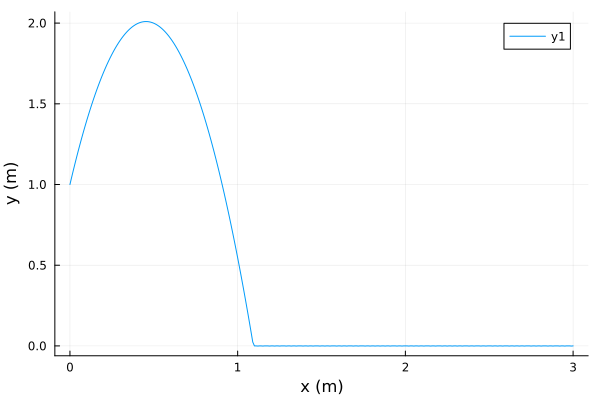

iteration_number: 3 
iteration_number: 4 
iteration_number: 5 
iteration_number: 6 
iteration_number: 7 
iteration_number: 8 
iteration_number: 9 
iteration_number: 1 
iteration_number: 1 
iteration_number: 2 
iteration_number: 3 
iteration_number: 4 
iteration_number: 5 
iteration_number: 6 
iteration_number: 7 
iteration_number: 8 
iteration_number: 9 
iteration_number: 1 
iteration_number: 1 
iteration_number: 2 
iteration_number: 3 
iteration_number: 4 
iteration_number: 5 
iteration_number: 6 
iteration_number: 7 
iteration_number: 8 
iteration_number: 9 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 2 
iteration_number: 3 
iteration_number: 4 
iteration_number: 5 
iteration_number: 6 
iteration_number: 7 
iteration_number: 8 
iteration_number: 9 
iteration_number: 1 
iteration_number: 1 
iteration_number: 1 
iteration_number: 2 
iteration_number: 3 
iteration_number: 4 
iteration_number: 5 
iteration_number: 6 
iteration_number: 7 
iteration_num

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /Users/soroushjalali/.julia/packages/MeshCat/oC0sL/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8702))

In [46]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for k in 1:(N-1)
        qp = brick_simulation_qp(qs[k], vs[k])
        vs[k+1], _ , _ = solve_qp(qp; verbose = false, tol = 1e-4)
        qs[k+1] = qs[k] + dt* vs[k+1]
    end


    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end